## Libaries
Make sure all the required libaries with correct version are installed
- python >3.6
- numpy >1.19.2
- pandas >0.25.1
- matplotlib >3.3.4
- tensorflow >2.6
- ipympl >0.8.0
- ipython >7.16.1

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ControlDesign as CD
import IM_tf_maple as im
import tensorflow as tf
import SweepAnalysis as SA
from tensorflow.linalg import inv
%matplotlib ipympl

# Case study with known design specifications
The analytical impedance model is included in IM_tf_maple.py. Here, a case study is presented to show the effectiveness of the analytical model by comparing the impedance obtained through the analytical model with the simulation results. The simulation model is based on PLECS.

Let us start with a specific charger with the design parameters below.
|     Parameters                        |   Value   |     Unit      |
|     :---                              |   :---:   |     ---:      |
|     Power filter resistance R         |     2     |    $m\Omega$  |
|     Power filter inductance L         |    250    |    ${\mu}H$   |
|     Bandwidth of the PLL              |    30     |       Hz      |
|     Bandwidth of the current loop     |   1000    |       Hz      |
|     Bandwidth of the voltage loop     |   200     |       Hz      |
|     Swiitching Frequency $f_{sw}$     |   20      |       kHz     |
|     DC-link capacitor $C_{out}$       |   1.5     |   ${\mu}F$    |
|     DC-link voltage $V_{dc}$          |   800     |      $V$      |

Besides, we assume that the chargering power is 30kW whereas the grid voltage is 230Vrms and the frequency is 50Hz.

## Define the design specifications

In [2]:
Rfilter = 2e-2
Lfilter = 250e-6
Cout = 3000e-6 # Two 3 mF capacitors are connected in series at the DC side of the AC/DC converter
fsw = 20e3 # The switching frequency is 20 kHz
Vdc = 800  # The DC-link voltage is set to 800V
DCFC_Power = 30e3 # Operating power of the DC fast charger
Vsd = 230*np.sqrt(2)
Grid_Vsdq = np.array([Vsd, 0])
Grid_freq = 50 # The grid frequency is 50 Hz
fcPLL = 30 # Bandwidth of the PLL
fci = 800  # Bandwidth of the current control loop
fcv = 330   # Bandwidth of the voltage control loop
# phi_u = 45/180*np.pi # Phase margin of the voltage loop
f_sweep = np.concatenate([np.arange(1,50,10),np.arange(51,10000+1,10)]) # define the frequency span of the model, 50Hz need to be removed

Next, we will calculate the Kp and Ki for the PI compesator of the PLL, current controller, and voltage controller to meet the bandwidth requirement.

In [3]:
Kppll,Kipll,Kpi,Kii,Kpu,Kiu=CD.design_ctrl(fcPLL,fci,fcv,Lfilter,Rfilter,Vsd,Cout,Vdc,1,1)

Kpi:1.256637,
Kii:100.530965,
Kpu:6.148755,
Kiu:254.664516.


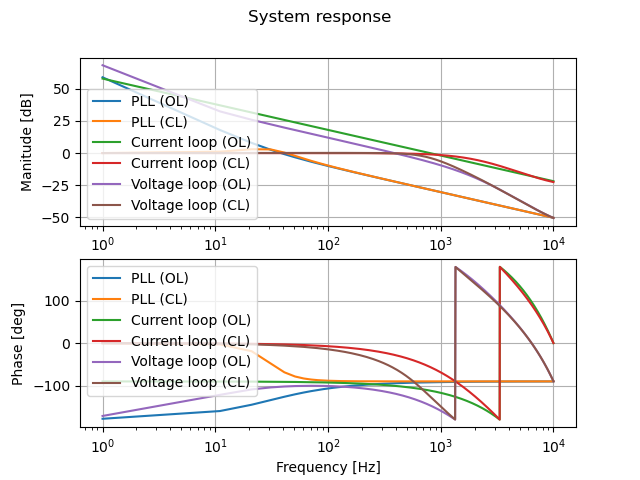

The bandwidth of the current loop is 711 Hz,            
The phase margin of the current loop is 70.803000 deg,            
The bandwidth of the voltage loop is 351 Hz,            
The phase margin of the voltage loop is 63.916979 deg.


In [4]:
CD.bode_plot(Rfilter,Lfilter,Kppll,Kipll,Kpi,Kii,Kpu,Kiu,Vsd,Vdc,Cout,fsw,f_sweep)

## Check the impedance modeling vs simulation

In [6]:
# Create the analytical model of the DCFC
Ana_model = im.Impedance_model1(Rfilter,Lfilter,Kpi,Kii,Kppll,Kipll,Kpu,Kiu,
                                fsw,Cout,Vdc,Grid_freq,Grid_Vsdq,DCFC_Power,f_sweep)

In [16]:
# Simulation results with switching model
fsweep_sim1 = np.arange(200,1100,100)
fsweep_sim2 = np.arange(60,100,10)
fsweep_sim = np.concatenate([fsweep_sim2,fsweep_sim1])
Zsweep_pn, Ysweep_pn = SA.Impedance_pnsweep(fsweep_sim,'.\sweep_results\pnPLL+CL+VL')

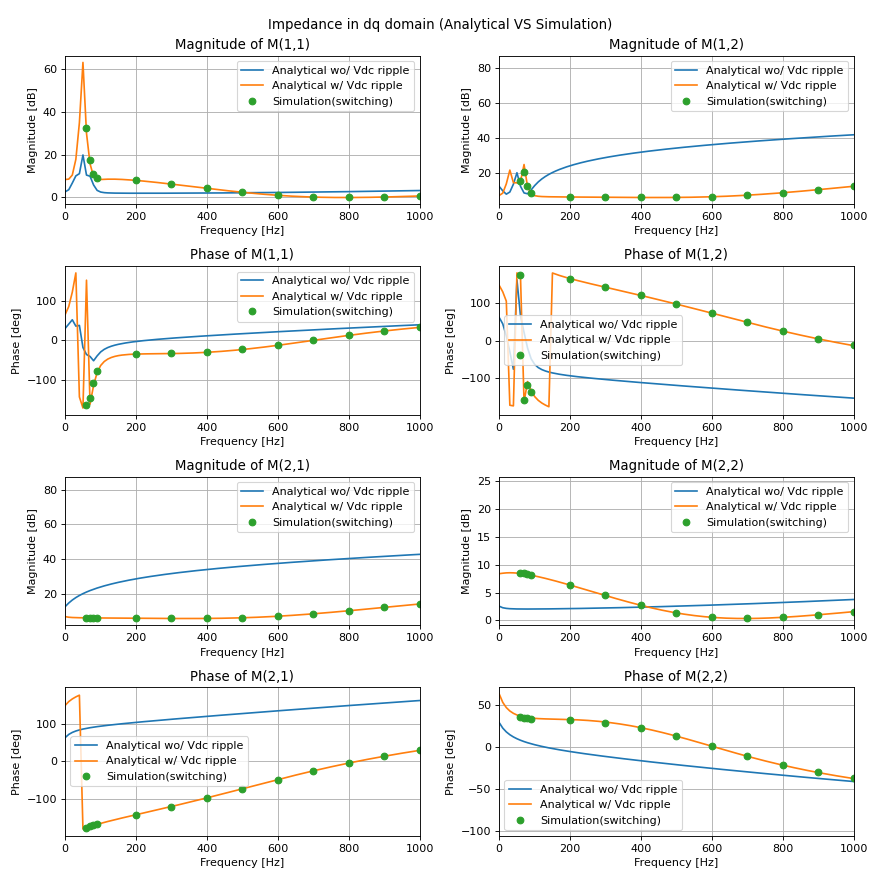

In [21]:
SA.Impedance_plotting(f_sweep,fsweep_sim,1,'Impedance in dq domain (Analytical VS Simulation)',[0,1000],
                        '-','-','o',**{'Analytical wo/ Vdc ripple':Ana_model.Zcl_ab_wo_vd,'Analytical w/ Vdc ripple':Ana_model.Zvl_ab,
                        'Simulation(switching)':Zsweep_pn})